<small><i>This notebook was put together by [Anderson Banihirwe](andersy005.github.io) as part of [2017 CISL/SIParCS Research Project](https://github.com/NCAR/PySpark4Climate): **PySpark for Big Atmospheric & Oceanic Data Analysis**</i></small>

# Table of Contents
- [1. Shapefiles in Python](#Shapefiles in Python)
- [1.1 Prerequisites](#Prerequisites)
- [1.2 Objectives](#Objectives)
- [1.3 Overview](#Overview)
- [1.4 Import Packages](#Import-Packages)
- [1.5 Create a Shapefile Object](#Create-a-shapefile-object)
- [1.6 Reading Geometry](#Reading-Geometry)
- [1.7 Reading Records](#Reading-Records)
- [1.8 Plotting a simple record](#Plotting-a-simple-record)
- [1.9 Plot all the states](#Plot-all-the-states)
- [1.10 Extra examples](#Extra-examples)

## Prerequisites
* Jupyter Notebooks installed and running
* The Python Shapefile Library (pyshp) packages: https://pypi.python.org/pypi/pyshp

## Objectives

* Inspect and Plot a shapefile

## Overview
- One of the most striking features of a shapefile is that the format consists of multiple files. At minimum, there are **three** and there can even be as many as **15 different files**.
- The following table describes the file formats. The .shp, .shx, and .dbf files are required for a valid shapefile.

| Shapefile supporting file extension | Supporting file purpose                                                                           | Notes                                                                 |
|-------------------------------------|---------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------|
| ```.shp```                          | It is a shapefile.  It contains the  geometry                                                     | Required file.                                                        |
| ```.shx```                          | It is the shape index file. It is fixed-size record index referencing geometry for faster access. | Required file. This file is meaningless  without the ```.shp``` file. |
| ```.dbf```                          | It is the database file. It contains the geometry atttributes.                                    | Required file.                                                        |

- Another important feature of shapefiles is that the records are not numbered. Records include the geometry, the ```.shx``` index record, and the ```.dbf``` record. These records are stored in a a fixed order.

- Deleting, saving, reopening a shapefile record is often confusing. The number of the record deleted still appears.
    - The reason is that the shapefile records are numbered dynamically on loading but not saved. So, if you delete record number 50 and save the shapefile, record number 51 will become 50 the next time you read the shapefile.
    - The only way to track shapefile records in this way is to create a new attribute called ID r similar in the ```.dbf``` file and assign each record a permanent, unique identifier.

## Import Packages

In [1]:
import shapefile
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
from matplotlib.cm import *
from IPython.display import Image as ImageShow


## Create a shapefile object
- Reads in the shapefile using states shapefile available [here](http://www.ncl.ucar.edu/Applications/Data/shp/states.shp).
- Create a new "Reader" object and pass it the name of an exisiting shapefile
- The shapefile format is actually a collection of three files. 
- You specify the base filename of the shapefile or the complete filename of any of the shapefile component files.

In [8]:
#   -- input --
sf = shapefile.Reader(r'/Users/abanihi/Documents/shapefiles/states')

In [9]:
print 'number of shapes imported: ', len(sf.shapes())

number of shapes imported:  49


This returns 49 for the 50 states. For each shape(or state), there are a number of attributes defined:
- bbox
- parts
- points and 
- shapeType

## Reading Geometry

- Get the list of the shapefile's geometry by calling the shapes() method
- The shapes method returns a list of Shape objects describing the geometry of each shape record

In [11]:
shapes  = sf.shapes()
shapes

[<shapefile._Shape instance at 0x10bfb29e0>,
 <shapefile._Shape instance at 0x10bfb2830>,
 <shapefile._Shape instance at 0x1136d2e18>,
 <shapefile._Shape instance at 0x1136d2ea8>,
 <shapefile._Shape instance at 0x1136d2f38>,
 <shapefile._Shape instance at 0x1136d2fc8>,
 <shapefile._Shape instance at 0x10a703518>,
 <shapefile._Shape instance at 0x10a703878>,
 <shapefile._Shape instance at 0x10a703b00>,
 <shapefile._Shape instance at 0x10a703c20>,
 <shapefile._Shape instance at 0x10a70b1b8>,
 <shapefile._Shape instance at 0x1136bd128>,
 <shapefile._Shape instance at 0x1136bd710>,
 <shapefile._Shape instance at 0x10d777200>,
 <shapefile._Shape instance at 0x10ca39908>,
 <shapefile._Shape instance at 0x10caed248>,
 <shapefile._Shape instance at 0x1136c9f38>,
 <shapefile._Shape instance at 0x1136d3170>,
 <shapefile._Shape instance at 0x10d868d40>,
 <shapefile._Shape instance at 0x10a6f3ef0>,
 <shapefile._Shape instance at 0x10daab368>,
 <shapefile._Shape instance at 0x10daa5a70>,
 <shapefil

In [12]:
len(shapes)

49

- Each shape record contains the following attributes

In [15]:
for name in dir(shapes[5]):
    if not name.startswith('__'):
        print name

bbox
parts
points
shapeType


- ```shapeType```: an integer representing the type of shape as defined by the shapefile specification.

In [16]:
shapes[5].shapeType

5

- ```bbox```: If the shape type contains multiple points this tuple describes the lower left (x,y) coordinate and upper right corner coordinate creating a complete box around the points. If the shapeType is a Null (```shapeType == 0```) then an ```AttributeError``` is raised.

In [18]:
# Get the bounding box of the 5th shape.
# Round coordinates to 3 decimal places
bbox = shapes[5].bbox
print ['%.3f' % coord for coord in bbox]

['-109.055', '36.989', '-102.037', '41.003']


- ```parts```: Parts simply group collections of points into shapes. If the shape record has multiple parts this attribute contains the index of the first point of each part. If there is only one part then a list containing 0 is returned.

In [19]:
shapes[5].parts

[0]

- ```points```: The points attribute contains a list of tuples containing an (x,y) coordinate for each point in the shape.

In [20]:
len(shapes[5].points)

56

## Reading Records
- A record in a shapefile contains the attributes for each shape in the collection of geometry. 
- Records are stored in the dbf file. 
- The link between geometry and attributes is the foundation of all geographic information systems. 
- This critical link is implied by the order of shapes and corresponding records in the shp geometry file and the dbf attribute file.

The field names of a shapefile are available as soon as you read a shapefile. You can call the “fields” attribute of the shapefile as a Python list. Each field is a Python list with the following information:

- ```Field name```: the name describing the data at this column index.
- ```Field type```: the type of data at this column index. Types can be: Character, Numbers, Longs, Dates, or Memo. 
- ```Field length```: the length of the data found at this column index. 
- ```Decimal length```: the number of decimal places found in “Number” fields.

In [21]:
recs = sf.records()
len(recs)

49

- Each record is a list containing an attribute corresponding to each field in the field list.

In [49]:
recs[5][1:3]

['08', 'Mtn']

## Plotting a simple record

In [43]:
# Get all the information for a single shape(in this case, the 5th shape)
shape_ex = sf.shape(20)

The points attribute contains a list of latitude-longitude values that define the shape (state) boundary.
- Loop over those points to create an array of longitude and latitude values to plot.
- A single point can be accessed with shape_ex.points[0] and will return a lon/lat pair, e.g. (-70.13123,40.6210).  - Pull out the first and second index and put them in pre-defined numpy arrays:

In [44]:
x_lon = np.zeros((len(shape_ex.points), 1))
y_lat = np.zeros((len(shape_ex.points), 1))
for ip in range(len(shape_ex.points)):
    x_lon[ip] = shape_ex.points[ip][0]
    y_lat[ip] = shape_ex.points[ip][1]

(-94.617035, -89.645401)

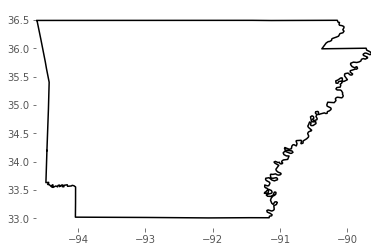

In [45]:
#   -- plot --
fig     = plt.figure()
ax      = fig.add_subplot(111)
ax.get_yaxis().set_visible(True)
ax.get_xaxis().set_visible(True)
ax.set_frame_on(False)
plt.plot(x_lon,y_lat,'k')

# use bbox (bounding box) to set plot limits
plt.xlim(shape_ex.bbox[0],shape_ex.bbox[2])

## Plot all the states

In [60]:
def plot(sf):
    
    #   -- plot --
    fig     = plt.figure()
    ax      = fig.add_subplot(111)
    ax.get_yaxis().set_visible(True)
    ax.get_xaxis().set_visible(True)
    ax.set_frame_on(False)
    
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x,y)
        
    plt.show()

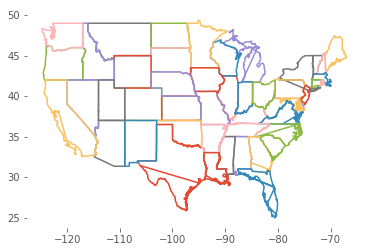

In [61]:
plot(sf)

## Extra examples

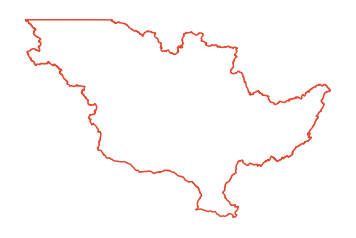

In [5]:
sf2 = shapefile.Reader(r'/Users/abanihi/Documents/shapefiles/mrb.shp')
plot(sf2)

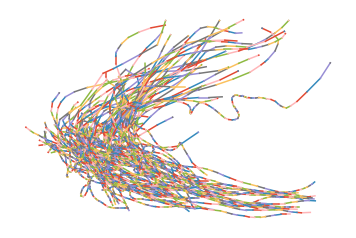

In [6]:
sf3 = shapefile.Reader(r'/Users/abanihi/Documents/shapefiles/hurmjrl020.shp')
plot(sf3)